In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
import os
os.system('kaggle datasets download -d uciml/breast-cancer-wisconsin-data -f data.csv');

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Create X and Y

In [5]:
DIAGNOSIS = 'diagnosis'
TARGET = 'radius_mean'
FEATURES_PREFIX = 'mean'
FEATURES = [feature for feature in df.columns if \
            (feature not in TARGET) and (FEATURES_PREFIX in feature)]
N_FEATURES = len(FEATURES)

In [6]:
y = df[TARGET]
x = df[FEATURES]
x.head()

,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [7]:
diagnosis = df[DIAGNOSIS]

## Preprocess data

In [8]:
x /= x.max(axis=0)

In [9]:
x.head()

,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0.264257,0.651459,0.400240,0.724602,0.803706,0.703140,0.731113,0.795724,0.807779
1,0.452393,0.705040,0.530188,0.518605,0.227678,0.203608,0.348757,0.596053,0.581589
2,0.540988,0.689655,0.481008,0.670747,0.462942,0.462512,0.635686,0.680592,0.615661
3,0.518839,0.411565,0.154378,0.872093,0.821946,0.565604,0.522863,0.854276,1.000000
4,0.365071,0.716711,0.518593,0.613831,0.384482,0.463918,0.518390,0.595066,0.603756


## Split Train, Val & Test

### Train & Val

In [10]:
x_healthy, y_healthy = x[diagnosis == 'B'], y[diagnosis == 'B']

In [11]:
TRAIN_SIZE = int(0.8 * len(x_healthy))

In [12]:
np.random.seed(0)
train_idxs = np.random.choice(x_healthy.index, TRAIN_SIZE, replace=False)
val_idxs = x_healthy.index.drop(train_idxs)

In [13]:
e = x_healthy.loc[train_idxs].values
y_train = y_healthy.loc[train_idxs].values
print('# Examples for training:',  len(x_train))

x_val = x_healthy.loc[val_idxs].values
y_val = y_healthy.loc[val_idxs].values
print('# Examples for validation:',  len(x_val))

# Examples for training: 285
# Examples for validation: 72


### Test

In [14]:
x_unhealthy, y_unhealthy = x[diagnosis == 'M'], y[diagnosis == 'M']

In [15]:
x_test = x_unhealthy.values
y_test = y_unhealthy.values
print('# Examples for test:',  len(x_test))

# Examples for test: 212


## Ensemble of models

### Create an ensemble of models

In [120]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

In [136]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(i)
#     h = Dropout(0.6)(h)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [137]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [138]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 9)                 0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                640       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 65        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


### Train ensemble

In [139]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [140]:
histories = defaultdict(lambda: None)

In [141]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train], (x_val, y_val), lr, 500, history=histories[i])

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 4s 14ms/step - loss: 151.7268 - mean_squared_error: 151.4692 - val_loss: 41.7251 - val_mean_squared_error: 37.3880
Epoch 2/50
285/285 [==============================] - 0s 29us/step - loss: 43.5521 - mean_squared_error: 39.2150 - val_loss: 3367.3188 - val_mean_squared_error: 3360.2642
Epoch 3/50
285/285 [==============================] - 0s 26us/step - loss: 3174.1038 - mean_squared_error: 3167.0491 - val_loss: 281.1982 - val_mean_squared_error: 275.4937
Epoch 4/50
285/285 [==============================] - 0s 32us/step - loss: 260.8189 - mean_squared_error: 255.1145 - val_loss: 503.8671 - val_mean_squared_error: 498.1130
Epoch 5/50
285/285 [==============================] - 0s 28us/step - loss: 490.3260 - mean_squared_error: 484.5719 - val_loss: 766.7534 - val_mean_squared_error: 762.1720
Epoch 6/50
285/285 [==============================] - 0s 24us/step - loss: 742.5373 - mean_squared_e

Epoch 50/50
285/285 [==============================] - 0s 14us/step - loss: 9.9652 - mean_squared_error: 1.2250 - val_loss: 11.4446 - val_mean_squared_error: 2.8227
Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 16ms/step - loss: 150.8597 - mean_squared_error: 150.6052 - val_loss: 51.6184 - val_mean_squared_error: 47.2812
Epoch 2/50
285/285 [==============================] - 0s 32us/step - loss: 47.1374 - mean_squared_error: 42.8001 - val_loss: 2332.5811 - val_mean_squared_error: 2327.3494
Epoch 3/50
285/285 [==============================] - 0s 31us/step - loss: 2242.5471 - mean_squared_error: 2237.3154 - val_loss: 18.9788 - val_mean_squared_error: 13.6681
Epoch 4/50
285/285 [==============================] - 0s 27us/step - loss: 17.8015 - mean_squared_error: 12.4907 - val_loss: 1508.3330 - val_mean_squared_error: 1502.6152
Epoch 5/50
285/285 [==============================] - 0s 26us/step - loss: 1421.0466 - mean_squared_error: 1

Epoch 49/50
285/285 [==============================] - 0s 26us/step - loss: 9.4759 - mean_squared_error: 2.2132 - val_loss: 9.4037 - val_mean_squared_error: 2.1505
Epoch 50/50
285/285 [==============================] - 0s 33us/step - loss: 9.6530 - mean_squared_error: 2.3997 - val_loss: 10.6279 - val_mean_squared_error: 3.4016
Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 4s 14ms/step - loss: 152.4881 - mean_squared_error: 152.2590 - val_loss: 7.4015 - val_mean_squared_error: 3.0973
Epoch 2/50
285/285 [==============================] - 0s 25us/step - loss: 8.1444 - mean_squared_error: 3.8402 - val_loss: 34.1454 - val_mean_squared_error: 26.5551
Epoch 3/50
285/285 [==============================] - 0s 30us/step - loss: 32.4025 - mean_squared_error: 24.8122 - val_loss: 3627.5750 - val_mean_squared_error: 3618.3420
Epoch 4/50
285/285 [==============================] - 0s 29us/step - loss: 3456.3398 - mean_squared_error: 3447.1069 - val_

Epoch 48/50
285/285 [==============================] - 0s 46us/step - loss: 16.8874 - mean_squared_error: 6.6878 - val_loss: 12.9294 - val_mean_squared_error: 2.7807
Epoch 49/50
285/285 [==============================] - 0s 0us/step - loss: 12.8785 - mean_squared_error: 2.7298 - val_loss: 10.3601 - val_mean_squared_error: 0.2815
Epoch 50/50
285/285 [==============================] - 0s 59us/step - loss: 10.3654 - mean_squared_error: 0.2867 - val_loss: 11.7033 - val_mean_squared_error: 1.6961
Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 4s 14ms/step - loss: 150.8208 - mean_squared_error: 150.5901 - val_loss: 17.2982 - val_mean_squared_error: 12.9821
Epoch 2/50
285/285 [==============================] - 0s 33us/step - loss: 16.2531 - mean_squared_error: 11.9370 - val_loss: 3193.7944 - val_mean_squared_error: 3186.9724
Epoch 3/50
285/285 [==============================] - 0s 34us/step - loss: 3059.5984 - mean_squared_error: 3052.7764 -

Epoch 47/50
285/285 [==============================] - 0s 63us/step - loss: 9.8260 - mean_squared_error: 2.7104 - val_loss: 10.7012 - val_mean_squared_error: 3.6307
Epoch 48/50
285/285 [==============================] - 0s 36us/step - loss: 11.4554 - mean_squared_error: 4.3850 - val_loss: 11.3206 - val_mean_squared_error: 4.2880
Epoch 49/50
285/285 [==============================] - 0s 0us/step - loss: 12.0811 - mean_squared_error: 5.0485 - val_loss: 10.1779 - val_mean_squared_error: 3.1754
Epoch 50/50
285/285 [==============================] - 0s 78us/step - loss: 10.8574 - mean_squared_error: 3.8548 - val_loss: 8.7867 - val_mean_squared_error: 1.8086
Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 4s 14ms/step - loss: 152.7791 - mean_squared_error: 152.5501 - val_loss: 14.0844 - val_mean_squared_error: 11.1539
Epoch 2/50
285/285 [==============================] - 0s 32us/step - loss: 15.7217 - mean_squared_error: 12.7912 - val_loss: 

Epoch 46/50
285/285 [==============================] - 0s 27us/step - loss: 10.7018 - mean_squared_error: 3.4063 - val_loss: 8.8291 - val_mean_squared_error: 1.6063
Epoch 47/50
285/285 [==============================] - 0s 34us/step - loss: 8.9791 - mean_squared_error: 1.7562 - val_loss: 8.1934 - val_mean_squared_error: 1.0412
Epoch 48/50
285/285 [==============================] - 0s 25us/step - loss: 8.1760 - mean_squared_error: 1.0238 - val_loss: 9.9967 - val_mean_squared_error: 2.9184
Epoch 49/50
285/285 [==============================] - 0s 23us/step - loss: 9.8086 - mean_squared_error: 2.7304 - val_loss: 7.5451 - val_mean_squared_error: 0.5499
Epoch 50/50
285/285 [==============================] - 0s 25us/step - loss: 7.5670 - mean_squared_error: 0.5718 - val_loss: 8.3506 - val_mean_squared_error: 1.4406
Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 4s 15ms/step - loss: 11.6813 - mean_squared_error: 3.0595 - val_loss: 143.6346

Epoch 95/100
285/285 [==============================] - 0s 28us/step - loss: 7.0932 - mean_squared_error: 0.7535 - val_loss: 7.0167 - val_mean_squared_error: 0.7394
Epoch 96/100
285/285 [==============================] - 0s 25us/step - loss: 7.1585 - mean_squared_error: 0.8812 - val_loss: 7.2533 - val_mean_squared_error: 1.0305
Epoch 97/100
285/285 [==============================] - 0s 35us/step - loss: 7.3868 - mean_squared_error: 1.1640 - val_loss: 7.2652 - val_mean_squared_error: 1.0886
Epoch 98/100
285/285 [==============================] - 0s 28us/step - loss: 7.3933 - mean_squared_error: 1.2168 - val_loss: 6.9873 - val_mean_squared_error: 0.8489
Epoch 99/100
285/285 [==============================] - 0s 32us/step - loss: 7.1174 - mean_squared_error: 0.9790 - val_loss: 6.7042 - val_mean_squared_error: 0.5985
Epoch 100/100
285/285 [==============================] - 0s 28us/step - loss: 6.8343 - mean_squared_error: 0.7286 - val_loss: 6.6647 - val_mean_squared_error: 0.5904
Train on 

Epoch 94/100
285/285 [==============================] - 0s 37us/step - loss: 6.2786 - mean_squared_error: 1.7602 - val_loss: 5.8488 - val_mean_squared_error: 1.3671
Epoch 95/100
285/285 [==============================] - 0s 38us/step - loss: 6.0861 - mean_squared_error: 1.6044 - val_loss: 5.5124 - val_mean_squared_error: 1.0628
Epoch 96/100
285/285 [==============================] - 0s 38us/step - loss: 5.7359 - mean_squared_error: 1.2864 - val_loss: 5.3261 - val_mean_squared_error: 0.9064
Epoch 97/100
285/285 [==============================] - 0s 43us/step - loss: 5.5242 - mean_squared_error: 1.1044 - val_loss: 5.3979 - val_mean_squared_error: 1.0075
Epoch 98/100
285/285 [==============================] - 0s 47us/step - loss: 5.5632 - mean_squared_error: 1.1728 - val_loss: 5.5430 - val_mean_squared_error: 1.1844
Epoch 99/100
285/285 [==============================] - 0s 51us/step - loss: 5.6828 - mean_squared_error: 1.3241 - val_loss: 5.5292 - val_mean_squared_error: 1.2080
Epoch 100/

Epoch 93/100
285/285 [==============================] - 0s 26us/step - loss: 10.8222 - mean_squared_error: 2.9614 - val_loss: 8.1307 - val_mean_squared_error: 0.2887
Epoch 94/100
285/285 [==============================] - 0s 34us/step - loss: 8.1077 - mean_squared_error: 0.2657 - val_loss: 8.6486 - val_mean_squared_error: 0.8239
Epoch 95/100
285/285 [==============================] - 0s 25us/step - loss: 8.6423 - mean_squared_error: 0.8176 - val_loss: 11.1454 - val_mean_squared_error: 3.3404
Epoch 96/100
285/285 [==============================] - 0s 39us/step - loss: 11.0481 - mean_squared_error: 3.2431 - val_loss: 12.5262 - val_mean_squared_error: 4.7453
Epoch 97/100
285/285 [==============================] - 0s 42us/step - loss: 12.3706 - mean_squared_error: 4.5898 - val_loss: 11.3417 - val_mean_squared_error: 3.5899
Epoch 98/100
285/285 [==============================] - 0s 37us/step - loss: 11.2297 - mean_squared_error: 3.4779 - val_loss: 8.9908 - val_mean_squared_error: 1.2715
Epo

Epoch 93/100
285/285 [==============================] - 0s 36us/step - loss: 5.9634 - mean_squared_error: 1.3706 - val_loss: 5.6003 - val_mean_squared_error: 1.0424
Epoch 94/100
285/285 [==============================] - 0s 33us/step - loss: 5.8105 - mean_squared_error: 1.2526 - val_loss: 5.4077 - val_mean_squared_error: 0.8758
Epoch 95/100
285/285 [==============================] - 0s 18us/step - loss: 5.6014 - mean_squared_error: 1.0694 - val_loss: 5.3611 - val_mean_squared_error: 0.8517
Epoch 96/100
285/285 [==============================] - 0s 40us/step - loss: 5.5316 - mean_squared_error: 1.0222 - val_loss: 5.4298 - val_mean_squared_error: 0.9479
Epoch 97/100
285/285 [==============================] - 0s 48us/step - loss: 5.5790 - mean_squared_error: 1.0971 - val_loss: 5.4257 - val_mean_squared_error: 0.9804
Epoch 98/100
285/285 [==============================] - 0s 25us/step - loss: 5.5674 - mean_squared_error: 1.1222 - val_loss: 5.2841 - val_mean_squared_error: 0.8859
Epoch 99/1

Epoch 92/100
285/285 [==============================] - 0s 30us/step - loss: 5.6972 - mean_squared_error: 1.3852 - val_loss: 5.4362 - val_mean_squared_error: 1.1690
Epoch 93/100
285/285 [==============================] - 0s 35us/step - loss: 5.4338 - mean_squared_error: 1.1667 - val_loss: 4.9112 - val_mean_squared_error: 0.6945
Epoch 94/100
285/285 [==============================] - 0s 47us/step - loss: 4.9683 - mean_squared_error: 0.7516 - val_loss: 4.6338 - val_mean_squared_error: 0.4687
Epoch 95/100
285/285 [==============================] - 0s 33us/step - loss: 4.7451 - mean_squared_error: 0.5800 - val_loss: 4.7259 - val_mean_squared_error: 0.6111
Epoch 96/100
285/285 [==============================] - 0s 28us/step - loss: 4.8664 - mean_squared_error: 0.7516 - val_loss: 4.9081 - val_mean_squared_error: 0.8391
Epoch 97/100
285/285 [==============================] - 0s 43us/step - loss: 5.0557 - mean_squared_error: 0.9866 - val_loss: 4.8707 - val_mean_squared_error: 0.8421
Epoch 98/1

285/285 [==============================] - 0s 26us/step - loss: 5.1521 - mean_squared_error: 0.5110 - val_loss: 5.0608 - val_mean_squared_error: 0.4532
Epoch 142/150
285/285 [==============================] - 0s 24us/step - loss: 5.1365 - mean_squared_error: 0.5289 - val_loss: 4.9550 - val_mean_squared_error: 0.3861
Epoch 143/150
285/285 [==============================] - 0s 17us/step - loss: 5.0304 - mean_squared_error: 0.4615 - val_loss: 4.8685 - val_mean_squared_error: 0.3404
Epoch 144/150
285/285 [==============================] - 0s 20us/step - loss: 4.9403 - mean_squared_error: 0.4122 - val_loss: 4.8676 - val_mean_squared_error: 0.3792
Epoch 145/150
285/285 [==============================] - 0s 31us/step - loss: 4.9318 - mean_squared_error: 0.4434 - val_loss: 4.8821 - val_mean_squared_error: 0.4296
Epoch 146/150
285/285 [==============================] - 0s 34us/step - loss: 4.9402 - mean_squared_error: 0.4877 - val_loss: 4.8285 - val_mean_squared_error: 0.4089
Epoch 147/150
285/

Epoch 141/150
285/285 [==============================] - 0s 28us/step - loss: 3.8451 - mean_squared_error: 0.7337 - val_loss: 3.6753 - val_mean_squared_error: 0.5930
Epoch 142/150
285/285 [==============================] - 0s 36us/step - loss: 3.7829 - mean_squared_error: 0.7006 - val_loss: 3.5932 - val_mean_squared_error: 0.5430
Epoch 143/150
285/285 [==============================] - 0s 18us/step - loss: 3.7010 - mean_squared_error: 0.6509 - val_loss: 3.5650 - val_mean_squared_error: 0.5466
Epoch 144/150
285/285 [==============================] - 0s 33us/step - loss: 3.6700 - mean_squared_error: 0.6516 - val_loss: 3.5710 - val_mean_squared_error: 0.5819
Epoch 145/150
285/285 [==============================] - 0s 36us/step - loss: 3.6714 - mean_squared_error: 0.6823 - val_loss: 3.5430 - val_mean_squared_error: 0.5794
Epoch 146/150
285/285 [==============================] - 0s 20us/step - loss: 3.6410 - mean_squared_error: 0.6774 - val_loss: 3.4777 - val_mean_squared_error: 0.5357
Epoc

Epoch 140/150
285/285 [==============================] - 0s 24us/step - loss: 6.7648 - mean_squared_error: 0.2203 - val_loss: 6.6732 - val_mean_squared_error: 0.1599
Epoch 141/150
285/285 [==============================] - 0s 23us/step - loss: 6.6677 - mean_squared_error: 0.1545 - val_loss: 7.1659 - val_mean_squared_error: 0.6821
Epoch 142/150
285/285 [==============================] - 0s 23us/step - loss: 7.1289 - mean_squared_error: 0.6451 - val_loss: 7.3435 - val_mean_squared_error: 0.8851
Epoch 143/150
285/285 [==============================] - 0s 23us/step - loss: 7.2955 - mean_squared_error: 0.8371 - val_loss: 6.9169 - val_mean_squared_error: 0.4809
Epoch 144/150
285/285 [==============================] - 0s 20us/step - loss: 6.8917 - mean_squared_error: 0.4558 - val_loss: 6.5095 - val_mean_squared_error: 0.0938
Epoch 145/150
285/285 [==============================] - 0s 24us/step - loss: 6.5097 - mean_squared_error: 0.0940 - val_loss: 6.6147 - val_mean_squared_error: 0.2191
Epoc

Epoch 140/150
285/285 [==============================] - 0s 27us/step - loss: 4.3319 - mean_squared_error: 0.7683 - val_loss: 4.1430 - val_mean_squared_error: 0.5843
Epoch 141/150
285/285 [==============================] - 0s 38us/step - loss: 4.2578 - mean_squared_error: 0.6991 - val_loss: 4.1520 - val_mean_squared_error: 0.5989
Epoch 142/150
285/285 [==============================] - 0s 20us/step - loss: 4.2628 - mean_squared_error: 0.7096 - val_loss: 4.1854 - val_mean_squared_error: 0.6425
Epoch 143/150
285/285 [==============================] - 0s 35us/step - loss: 4.2915 - mean_squared_error: 0.7487 - val_loss: 4.1640 - val_mean_squared_error: 0.6384
Epoch 144/150
285/285 [==============================] - 0s 16us/step - loss: 4.2683 - mean_squared_error: 0.7427 - val_loss: 4.0871 - val_mean_squared_error: 0.5845
Epoch 145/150
285/285 [==============================] - 0s 25us/step - loss: 4.1921 - mean_squared_error: 0.6895 - val_loss: 4.0203 - val_mean_squared_error: 0.5452
Epoc

Epoch 139/150
285/285 [==============================] - 0s 33us/step - loss: 3.4129 - mean_squared_error: 0.5108 - val_loss: 3.2001 - val_mean_squared_error: 0.3178
Epoch 140/150
285/285 [==============================] - 0s 12us/step - loss: 3.2656 - mean_squared_error: 0.3832 - val_loss: 3.1333 - val_mean_squared_error: 0.2668
Epoch 141/150
285/285 [==============================] - 0s 36us/step - loss: 3.1995 - mean_squared_error: 0.3329 - val_loss: 3.1781 - val_mean_squared_error: 0.3269
Epoch 142/150
285/285 [==============================] - 0s 26us/step - loss: 3.2408 - mean_squared_error: 0.3896 - val_loss: 3.1952 - val_mean_squared_error: 0.3629
Epoch 143/150
285/285 [==============================] - 0s 27us/step - loss: 3.2554 - mean_squared_error: 0.4232 - val_loss: 3.1124 - val_mean_squared_error: 0.3031
Epoch 144/150
285/285 [==============================] - 0s 32us/step - loss: 3.1730 - mean_squared_error: 0.3637 - val_loss: 3.0239 - val_mean_squared_error: 0.2396
Epoc

Epoch 189/200
285/285 [==============================] - 0s 35us/step - loss: 4.0176 - mean_squared_error: 0.3372 - val_loss: 3.9552 - val_mean_squared_error: 0.2941
Epoch 190/200
285/285 [==============================] - 0s 31us/step - loss: 3.9969 - mean_squared_error: 0.3359 - val_loss: 3.9293 - val_mean_squared_error: 0.2868
Epoch 191/200
285/285 [==============================] - 0s 31us/step - loss: 3.9725 - mean_squared_error: 0.3301 - val_loss: 3.9044 - val_mean_squared_error: 0.2795
Epoch 192/200
285/285 [==============================] - 0s 28us/step - loss: 3.9502 - mean_squared_error: 0.3253 - val_loss: 3.8838 - val_mean_squared_error: 0.2763
Epoch 193/200
285/285 [==============================] - 0s 26us/step - loss: 3.9317 - mean_squared_error: 0.3242 - val_loss: 3.8644 - val_mean_squared_error: 0.2754
Epoch 194/200
285/285 [==============================] - 0s 31us/step - loss: 3.9130 - mean_squared_error: 0.3239 - val_loss: 3.8442 - val_mean_squared_error: 0.2745
Epoc

285/285 [==============================] - 0s 35us/step - loss: 2.9039 - mean_squared_error: 0.4868 - val_loss: 2.8286 - val_mean_squared_error: 0.4250
Epoch 189/200
285/285 [==============================] - 0s 37us/step - loss: 2.8893 - mean_squared_error: 0.4857 - val_loss: 2.8110 - val_mean_squared_error: 0.4204
Epoch 190/200
285/285 [==============================] - 0s 28us/step - loss: 2.8716 - mean_squared_error: 0.4809 - val_loss: 2.7912 - val_mean_squared_error: 0.4129
Epoch 191/200
285/285 [==============================] - 0s 18us/step - loss: 2.8530 - mean_squared_error: 0.4747 - val_loss: 2.7737 - val_mean_squared_error: 0.4073
Epoch 192/200
285/285 [==============================] - 0s 35us/step - loss: 2.8370 - mean_squared_error: 0.4706 - val_loss: 2.7582 - val_mean_squared_error: 0.4043
Epoch 193/200
285/285 [==============================] - 0s 29us/step - loss: 2.8221 - mean_squared_error: 0.4682 - val_loss: 2.7427 - val_mean_squared_error: 0.4021
Epoch 194/200
285/

Epoch 188/200
285/285 [==============================] - 0s 33us/step - loss: 5.7435 - mean_squared_error: 0.0941 - val_loss: 5.7248 - val_mean_squared_error: 0.0956
Epoch 189/200
285/285 [==============================] - 0s 23us/step - loss: 5.7252 - mean_squared_error: 0.0960 - val_loss: 5.6847 - val_mean_squared_error: 0.0748
Epoch 190/200
285/285 [==============================] - 0s 28us/step - loss: 5.6870 - mean_squared_error: 0.0770 - val_loss: 5.6579 - val_mean_squared_error: 0.0670
Epoch 191/200
285/285 [==============================] - 0s 32us/step - loss: 5.6619 - mean_squared_error: 0.0710 - val_loss: 5.6498 - val_mean_squared_error: 0.0785
Epoch 192/200
285/285 [==============================] - 0s 32us/step - loss: 5.6542 - mean_squared_error: 0.0829 - val_loss: 5.6316 - val_mean_squared_error: 0.0803
Epoch 193/200
285/285 [==============================] - 0s 36us/step - loss: 5.6361 - mean_squared_error: 0.0848 - val_loss: 5.5990 - val_mean_squared_error: 0.0687
Epoc

285/285 [==============================] - 0s 30us/step - loss: 2.9363 - mean_squared_error: 0.2563 - val_loss: 2.8925 - val_mean_squared_error: 0.2325
Epoch 188/200
285/285 [==============================] - 0s 29us/step - loss: 2.9097 - mean_squared_error: 0.2497 - val_loss: 2.8703 - val_mean_squared_error: 0.2305
Epoch 189/200
285/285 [==============================] - 0s 30us/step - loss: 2.8839 - mean_squared_error: 0.2442 - val_loss: 2.8470 - val_mean_squared_error: 0.2271
Epoch 190/200
285/285 [==============================] - 0s 36us/step - loss: 2.8585 - mean_squared_error: 0.2386 - val_loss: 2.8207 - val_mean_squared_error: 0.2201
Epoch 191/200
285/285 [==============================] - 0s 31us/step - loss: 2.8323 - mean_squared_error: 0.2318 - val_loss: 2.7950 - val_mean_squared_error: 0.2135
Epoch 192/200
285/285 [==============================] - 0s 43us/step - loss: 2.8072 - mean_squared_error: 0.2257 - val_loss: 2.7711 - val_mean_squared_error: 0.2093
Epoch 193/200
285/

Epoch 187/200
285/285 [==============================] - 0s 23us/step - loss: 2.3115 - mean_squared_error: 0.1363 - val_loss: 2.2685 - val_mean_squared_error: 0.1085
Epoch 188/200
285/285 [==============================] - 0s 31us/step - loss: 2.2927 - mean_squared_error: 0.1327 - val_loss: 2.2507 - val_mean_squared_error: 0.1068
Epoch 189/200
285/285 [==============================] - 0s 29us/step - loss: 2.2722 - mean_squared_error: 0.1283 - val_loss: 2.2370 - val_mean_squared_error: 0.1093
Epoch 190/200
285/285 [==============================] - 0s 29us/step - loss: 2.2555 - mean_squared_error: 0.1278 - val_loss: 2.2228 - val_mean_squared_error: 0.1108
Epoch 191/200
285/285 [==============================] - 0s 25us/step - loss: 2.2397 - mean_squared_error: 0.1276 - val_loss: 2.2031 - val_mean_squared_error: 0.1062
Epoch 192/200
285/285 [==============================] - 0s 22us/step - loss: 2.2204 - mean_squared_error: 0.1235 - val_loss: 2.1826 - val_mean_squared_error: 0.1001
Epoc

## Predict target feature using ensemble

In [142]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))

## Use ensemble variance to predict diagnosis 

In [143]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

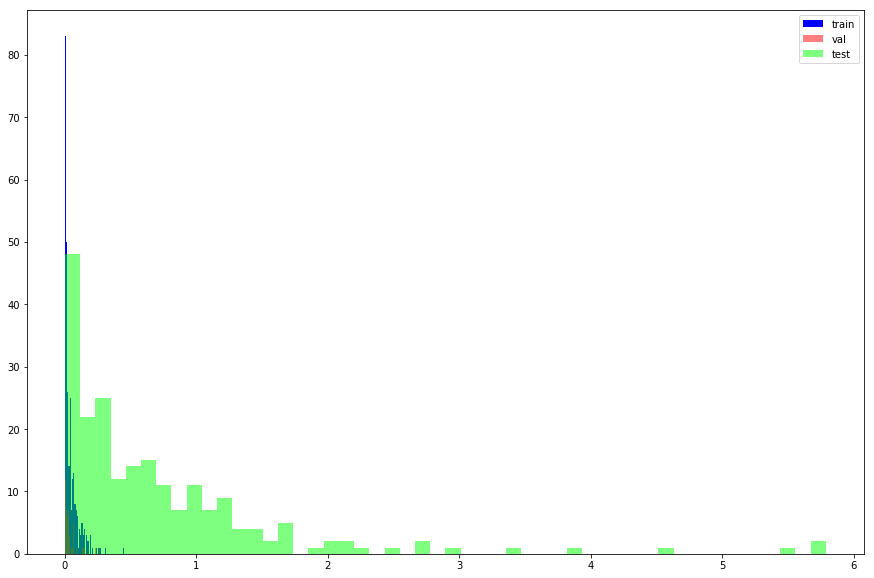

In [144]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=50, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [145]:
threshold_var = 1.5 * y_train_preds_var.mean()

In [146]:
train_acc = (y_train_preds_var < threshold_var).mean()
print(train_acc)

0.7859649122807018


### Validation & Test

In [147]:
val_acc = (y_val_preds_var < threshold_var).mean()
print(val_acc)

0.7916666666666666


In [148]:
test_acc = (y_test_preds_var >= threshold_var).mean()
print(test_acc)

0.8679245283018868


### But best single predictive variable is not known

In [83]:
x_healthy.loc[:, TARGET] = y_healthy
x_unhealthy.loc[:, TARGET] = y_unhealthy

c:\python36\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
c:\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


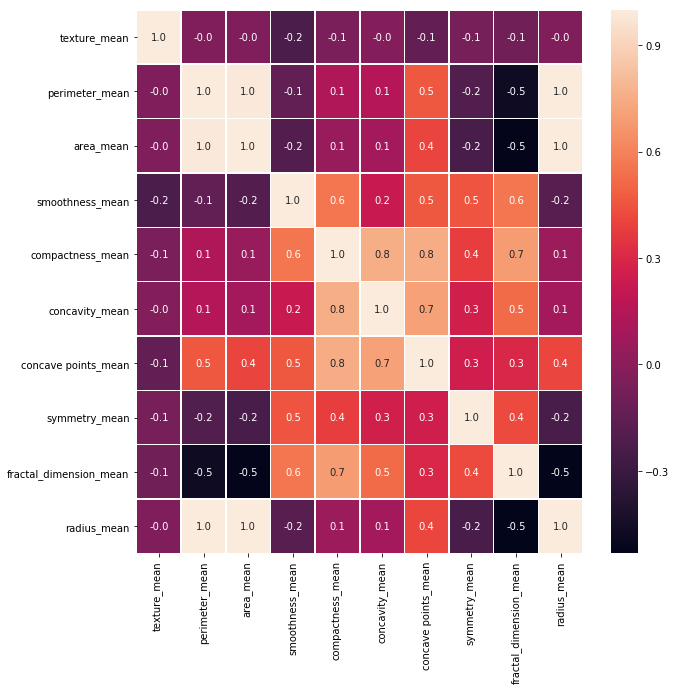

In [68]:
width = len(FEATURES + [TARGET])
f, ax = plt.subplots(figsize=(width, width))
sns.heatmap(x_healthy.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_healthy.values)

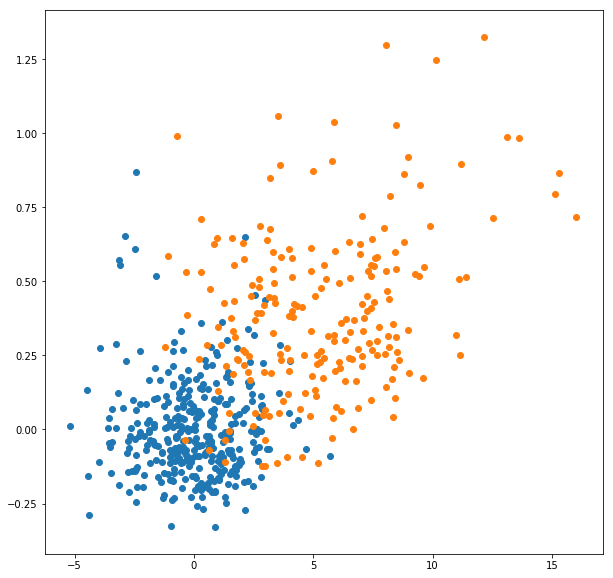

In [97]:
x_healthy_transformed = basis.transform(x_healthy)
x_unhealthy_transformed = basis.transform(x_unhealthy)

plt.figure(figsize=(width, width))
plt.scatter(x_healthy_transformed[:, 0], x_healthy_transformed[:, 1])
plt.scatter(x_unhealthy_transformed[:, 0], x_unhealthy_transformed[:, 1])

### Usage of the fewer dimentions for ensembling variance

In [160]:
TRAIN_SIZE = int(0.8 * len(x_healthy_transformed))
np.random.seed(0)
np.random.shuffle(x_healthy_transformed)
x_train_transformed = x_healthy_transformed[:TRAIN_SIZE, :-1]
y_train_transformed = x_healthy_transformed[:TRAIN_SIZE, -1]
print('# Examples for training:',  len(x_train_transformed))

x_val_transformed = x_healthy_transformed[TRAIN_SIZE:, :-1]
y_val_transformed = x_healthy_transformed[TRAIN_SIZE:, -1]
print('# Examples for validation:',  len(x_val_transformed))

N_FEATURES_TRANSFORMED = x_val_transformed.shape[-1]

# Examples for training: 285
# Examples for validation: 72


In [161]:
models = []
N_MODELS = 5
n_hidden_neurons = 32
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES_TRANSFORMED, n_hidden_neurons))

In [162]:
histories = defaultdict(lambda: None)

In [164]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train_transformed, y_train_transformed], (x_val_transformed, y_val_transformed), lr, 500, history=histories[i])

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 18ms/step - loss: 0.0464 - mean_squared_error: 0.0085 - val_loss: 39.6574 - val_mean_squared_error: 39.0028
Epoch 2/50
285/285 [==============================] - 0s 35us/step - loss: 27.6676 - mean_squared_error: 27.0130 - val_loss: 41.1289 - val_mean_squared_error: 40.4262
Epoch 3/50
285/285 [==============================] - 0s 35us/step - loss: 50.0969 - mean_squared_error: 49.3942 - val_loss: 6.3552 - val_mean_squared_error: 5.7358
Epoch 4/50
285/285 [==============================] - 0s 26us/step - loss: 5.5124 - mean_squared_error: 4.8930 - val_loss: 2.5036 - val_mean_squared_error: 1.8561
Epoch 5/50
285/285 [==============================] - 0s 25us/step - loss: 2.3777 - mean_squared_error: 1.7302 - val_loss: 11.1268 - val_mean_squared_error: 10.5168
Epoch 6/50
285/285 [==============================] - 0s 25us/step - loss: 9.1582 - mean_squared_error: 8.5482 - val_loss: 7.8746 

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 17ms/step - loss: 0.0461 - mean_squared_error: 0.0081 - val_loss: 38.1050 - val_mean_squared_error: 37.4513
Epoch 2/50
285/285 [==============================] - 0s 32us/step - loss: 31.0141 - mean_squared_error: 30.3603 - val_loss: 1.0192 - val_mean_squared_error: 0.6199
Epoch 3/50
285/285 [==============================] - 0s 26us/step - loss: 0.9888 - mean_squared_error: 0.5894 - val_loss: 2.8305 - val_mean_squared_error: 2.6499
Epoch 4/50
285/285 [==============================] - 0s 18us/step - loss: 3.3592 - mean_squared_error: 3.1786 - val_loss: 6.8395 - val_mean_squared_error: 6.5479
Epoch 5/50
285/285 [==============================] - 0s 27us/step - loss: 5.6181 - mean_squared_error: 5.3265 - val_loss: 4.2013 - val_mean_squared_error: 3.8252
Epoch 6/50
285/285 [==============================] - 0s 30us/step - loss: 3.8878 - mean_squared_error: 3.5117 - val_loss: 5.6403 - val_

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 18ms/step - loss: 0.0491 - mean_squared_error: 0.0127 - val_loss: 3.5906 - val_mean_squared_error: 3.1485
Epoch 2/50
285/285 [==============================] - 0s 26us/step - loss: 4.2756 - mean_squared_error: 3.8335 - val_loss: 83.4410 - val_mean_squared_error: 82.9952
Epoch 3/50
285/285 [==============================] - 0s 34us/step - loss: 96.4828 - mean_squared_error: 96.0370 - val_loss: 2.7900 - val_mean_squared_error: 2.3731
Epoch 4/50
285/285 [==============================] - 0s 32us/step - loss: 3.4179 - mean_squared_error: 3.0010 - val_loss: 6.8792 - val_mean_squared_error: 6.4077
Epoch 5/50
285/285 [==============================] - 0s 31us/step - loss: 5.1142 - mean_squared_error: 4.6427 - val_loss: 1.2047 - val_mean_squared_error: 0.7045
Epoch 6/50
285/285 [==============================] - 0s 27us/step - loss: 1.0935 - mean_squared_error: 0.5933 - val_loss: 17.9735 - val

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 18ms/step - loss: 0.0501 - mean_squared_error: 0.0125 - val_loss: 15.5612 - val_mean_squared_error: 15.1166
Epoch 2/50
285/285 [==============================] - 0s 25us/step - loss: 13.3319 - mean_squared_error: 12.8873 - val_loss: 86.3172 - val_mean_squared_error: 85.7782
Epoch 3/50
285/285 [==============================] - 0s 30us/step - loss: 70.7438 - mean_squared_error: 70.2047 - val_loss: 7.1734 - val_mean_squared_error: 6.7181
Epoch 4/50
285/285 [==============================] - 0s 33us/step - loss: 5.7824 - mean_squared_error: 5.3271 - val_loss: 1.3694 - val_mean_squared_error: 0.9218
Epoch 5/50
285/285 [==============================] - 0s 32us/step - loss: 1.1184 - mean_squared_error: 0.6707 - val_loss: 2.7993 - val_mean_squared_error: 2.3655
Epoch 6/50
285/285 [==============================] - 0s 28us/step - loss: 2.2186 - mean_squared_error: 1.7848 - val_loss: 0.7140 - 

Train on 285 samples, validate on 72 samples
Epoch 1/50
285/285 [==============================] - 5s 18ms/step - loss: 0.0452 - mean_squared_error: 0.0091 - val_loss: 2.9913 - val_mean_squared_error: 2.5465
Epoch 2/50
285/285 [==============================] - 0s 26us/step - loss: 2.7450 - mean_squared_error: 2.3002 - val_loss: 120.1102 - val_mean_squared_error: 119.6597
Epoch 3/50
285/285 [==============================] - 0s 26us/step - loss: 94.1666 - mean_squared_error: 93.7161 - val_loss: 1.6004 - val_mean_squared_error: 1.2578
Epoch 4/50
285/285 [==============================] - 0s 24us/step - loss: 1.1227 - mean_squared_error: 0.7802 - val_loss: 16.7762 - val_mean_squared_error: 16.4053
Epoch 5/50
285/285 [==============================] - 0s 11us/step - loss: 14.2632 - mean_squared_error: 13.8923 - val_loss: 4.4904 - val_mean_squared_error: 4.0878
Epoch 6/50
285/285 [==============================] - 0s 22us/step - loss: 3.7480 - mean_squared_error: 3.3454 - val_loss: 12.3010

Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 5s 16ms/step - loss: 0.4819 - mean_squared_error: 0.0635 - val_loss: 8.5275 - val_mean_squared_error: 8.1553
Epoch 52/100
285/285 [==============================] - 0s 27us/step - loss: 9.6796 - mean_squared_error: 9.3074 - val_loss: 0.9164 - val_mean_squared_error: 0.5799
Epoch 53/100
285/285 [==============================] - 0s 20us/step - loss: 0.9888 - mean_squared_error: 0.6523 - val_loss: 1.7421 - val_mean_squared_error: 1.4467
Epoch 54/100
285/285 [==============================] - 0s 27us/step - loss: 1.9534 - mean_squared_error: 1.6580 - val_loss: 4.3856 - val_mean_squared_error: 4.1179
Epoch 55/100
285/285 [==============================] - 0s 27us/step - loss: 4.9688 - mean_squared_error: 4.7012 - val_loss: 3.6710 - val_mean_squared_error: 3.4323
Epoch 56/100
285/285 [==============================] - 0s 21us/step - loss: 4.1398 - mean_squared_error: 3.9011 - val_loss: 1.495

Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 5s 19ms/step - loss: 0.1338 - mean_squared_error: 0.0305 - val_loss: 4.4890 - val_mean_squared_error: 4.3744
Epoch 52/100
285/285 [==============================] - 0s 26us/step - loss: 4.7479 - mean_squared_error: 4.6333 - val_loss: 0.3877 - val_mean_squared_error: 0.2875
Epoch 53/100
285/285 [==============================] - 0s 10us/step - loss: 0.4005 - mean_squared_error: 0.3003 - val_loss: 0.9879 - val_mean_squared_error: 0.9084
Epoch 54/100
285/285 [==============================] - 0s 24us/step - loss: 1.0315 - mean_squared_error: 0.9520 - val_loss: 2.4546 - val_mean_squared_error: 2.3707
Epoch 55/100
285/285 [==============================] - 0s 12us/step - loss: 2.5212 - mean_squared_error: 2.4373 - val_loss: 1.8887 - val_mean_squared_error: 1.8010
Epoch 56/100
285/285 [==============================] - 0s 31us/step - loss: 1.8983 - mean_squared_error: 1.8105 - val_loss: 0.609

Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 5s 19ms/step - loss: 0.3997 - mean_squared_error: 0.0959 - val_loss: 6.1888 - val_mean_squared_error: 5.8863
Epoch 52/100
285/285 [==============================] - 0s 35us/step - loss: 6.0100 - mean_squared_error: 5.7075 - val_loss: 0.4312 - val_mean_squared_error: 0.1279
Epoch 53/100
285/285 [==============================] - 0s 25us/step - loss: 0.4427 - mean_squared_error: 0.1395 - val_loss: 3.0743 - val_mean_squared_error: 2.7783
Epoch 54/100
285/285 [==============================] - 0s 32us/step - loss: 2.8451 - mean_squared_error: 2.5491 - val_loss: 4.1472 - val_mean_squared_error: 3.8535
Epoch 55/100
285/285 [==============================] - 0s 28us/step - loss: 3.8756 - mean_squared_error: 3.5819 - val_loss: 1.5258 - val_mean_squared_error: 1.2365
Epoch 56/100
285/285 [==============================] - 0s 14us/step - loss: 1.4044 - mean_squared_error: 1.1151 - val_loss: 0.306

Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 5s 19ms/step - loss: 0.2650 - mean_squared_error: 0.0214 - val_loss: 11.1345 - val_mean_squared_error: 10.8844
Epoch 52/100
285/285 [==============================] - 0s 25us/step - loss: 13.6551 - mean_squared_error: 13.4050 - val_loss: 1.1261 - val_mean_squared_error: 0.8731
Epoch 53/100
285/285 [==============================] - 0s 29us/step - loss: 1.2156 - mean_squared_error: 0.9625 - val_loss: 2.5225 - val_mean_squared_error: 2.2801
Epoch 54/100
285/285 [==============================] - 0s 24us/step - loss: 2.8081 - mean_squared_error: 2.5657 - val_loss: 5.7468 - val_mean_squared_error: 5.5021
Epoch 55/100
285/285 [==============================] - 0s 25us/step - loss: 6.9271 - mean_squared_error: 6.6824 - val_loss: 4.5660 - val_mean_squared_error: 4.3174
Epoch 56/100
285/285 [==============================] - 0s 28us/step - loss: 5.4324 - mean_squared_error: 5.1838 - val_loss: 1

Train on 285 samples, validate on 72 samples
Epoch 51/100
285/285 [==============================] - 5s 19ms/step - loss: 0.2661 - mean_squared_error: 0.0881 - val_loss: 9.3429 - val_mean_squared_error: 9.1564
Epoch 52/100
285/285 [==============================] - 0s 16us/step - loss: 10.0827 - mean_squared_error: 9.8962 - val_loss: 0.7909 - val_mean_squared_error: 0.6043
Epoch 53/100
285/285 [==============================] - 0s 24us/step - loss: 0.8492 - mean_squared_error: 0.6626 - val_loss: 2.1221 - val_mean_squared_error: 1.9492
Epoch 54/100
285/285 [==============================] - 0s 20us/step - loss: 2.2914 - mean_squared_error: 2.1185 - val_loss: 5.1938 - val_mean_squared_error: 5.0219
Epoch 55/100
285/285 [==============================] - 0s 28us/step - loss: 5.6379 - mean_squared_error: 5.4660 - val_loss: 3.8237 - val_mean_squared_error: 3.6442
Epoch 56/100
285/285 [==============================] - 0s 20us/step - loss: 4.1493 - mean_squared_error: 3.9698 - val_loss: 1.19

Train on 285 samples, validate on 72 samples
Epoch 101/150
285/285 [==============================] - 5s 19ms/step - loss: 0.0321 - mean_squared_error: 0.0077 - val_loss: 0.5303 - val_mean_squared_error: 0.5076
Epoch 102/150
285/285 [==============================] - 0s 29us/step - loss: 0.5661 - mean_squared_error: 0.5434 - val_loss: 0.0301 - val_mean_squared_error: 0.0064
Epoch 103/150
285/285 [==============================] - 0s 29us/step - loss: 0.0298 - mean_squared_error: 0.0061 - val_loss: 0.3370 - val_mean_squared_error: 0.3187
Epoch 104/150
285/285 [==============================] - 0s 24us/step - loss: 0.3381 - mean_squared_error: 0.3198 - val_loss: 0.3519 - val_mean_squared_error: 0.3289
Epoch 105/150
285/285 [==============================] - 0s 25us/step - loss: 0.3450 - mean_squared_error: 0.3219 - val_loss: 0.1224 - val_mean_squared_error: 0.0980
Epoch 106/150
285/285 [==============================] - 0s 26us/step - loss: 0.1117 - mean_squared_error: 0.0873 - val_loss:

285/285 [==============================] - 0s 21us/step - loss: 0.0140 - mean_squared_error: 0.0070 - val_loss: 0.0141 - val_mean_squared_error: 0.0079
Train on 285 samples, validate on 72 samples
Epoch 101/150
285/285 [==============================] - 5s 19ms/step - loss: 0.0316 - mean_squared_error: 0.0177 - val_loss: 0.5769 - val_mean_squared_error: 0.5411
Epoch 102/150
285/285 [==============================] - 0s 32us/step - loss: 0.5314 - mean_squared_error: 0.4956 - val_loss: 0.1261 - val_mean_squared_error: 0.0941
Epoch 103/150
285/285 [==============================] - 0s 29us/step - loss: 0.1096 - mean_squared_error: 0.0777 - val_loss: 0.0702 - val_mean_squared_error: 0.0569
Epoch 104/150
285/285 [==============================] - 0s 28us/step - loss: 0.0745 - mean_squared_error: 0.0613 - val_loss: 0.2729 - val_mean_squared_error: 0.2593
Epoch 105/150
285/285 [==============================] - 0s 31us/step - loss: 0.2698 - mean_squared_error: 0.2561 - val_loss: 0.2528 - val_

Epoch 150/150
285/285 [==============================] - 0s 17us/step - loss: 0.0160 - mean_squared_error: 0.0079 - val_loss: 0.0152 - val_mean_squared_error: 0.0076
Train on 285 samples, validate on 72 samples
Epoch 101/150
285/285 [==============================] - 4s 16ms/step - loss: 0.1957 - mean_squared_error: 0.0274 - val_loss: 1.1347 - val_mean_squared_error: 0.9588
Epoch 102/150
285/285 [==============================] - 0s 36us/step - loss: 0.7793 - mean_squared_error: 0.6034 - val_loss: 0.3249 - val_mean_squared_error: 0.1512
Epoch 103/150
285/285 [==============================] - 0s 29us/step - loss: 0.3483 - mean_squared_error: 0.1746 - val_loss: 0.4616 - val_mean_squared_error: 0.2943
Epoch 104/150
285/285 [==============================] - 0s 33us/step - loss: 0.3806 - mean_squared_error: 0.2134 - val_loss: 0.6082 - val_mean_squared_error: 0.4386
Epoch 105/150
285/285 [==============================] - 0s 44us/step - loss: 0.5459 - mean_squared_error: 0.3763 - val_loss:

Epoch 150/150
285/285 [==============================] - 0s 30us/step - loss: 0.1167 - mean_squared_error: 0.0081 - val_loss: 0.1196 - val_mean_squared_error: 0.0126
Train on 285 samples, validate on 72 samples
Epoch 101/150
285/285 [==============================] - 5s 19ms/step - loss: 0.1848 - mean_squared_error: 0.0361 - val_loss: 2.1702 - val_mean_squared_error: 2.0022
Epoch 102/150
285/285 [==============================] - 0s 9us/step - loss: 2.5115 - mean_squared_error: 2.3435 - val_loss: 0.3769 - val_mean_squared_error: 0.2135
Epoch 103/150
285/285 [==============================] - 0s 20us/step - loss: 0.4219 - mean_squared_error: 0.2585 - val_loss: 0.5923 - val_mean_squared_error: 0.4409
Epoch 104/150
285/285 [==============================] - 0s 28us/step - loss: 0.6210 - mean_squared_error: 0.4695 - val_loss: 1.3690 - val_mean_squared_error: 1.2210
Epoch 105/150
285/285 [==============================] - 0s 18us/step - loss: 1.5475 - mean_squared_error: 1.3996 - val_loss: 

Epoch 150/150
285/285 [==============================] - 0s 37us/step - loss: 0.1011 - mean_squared_error: 0.0100 - val_loss: 0.1096 - val_mean_squared_error: 0.0203
Train on 285 samples, validate on 72 samples
Epoch 101/150
285/285 [==============================] - 5s 18ms/step - loss: 0.0817 - mean_squared_error: 0.0416 - val_loss: 0.8483 - val_mean_squared_error: 0.8063
Epoch 102/150
285/285 [==============================] - 0s 28us/step - loss: 0.9278 - mean_squared_error: 0.8859 - val_loss: 0.0523 - val_mean_squared_error: 0.0075
Epoch 103/150
285/285 [==============================] - 0s 18us/step - loss: 0.0530 - mean_squared_error: 0.0082 - val_loss: 0.4837 - val_mean_squared_error: 0.4449
Epoch 104/150
285/285 [==============================] - 0s 26us/step - loss: 0.5233 - mean_squared_error: 0.4846 - val_loss: 0.4530 - val_mean_squared_error: 0.4103
Epoch 105/150
285/285 [==============================] - 0s 32us/step - loss: 0.4886 - mean_squared_error: 0.4459 - val_loss:

Epoch 150/150
285/285 [==============================] - 0s 27us/step - loss: 0.0186 - mean_squared_error: 0.0096 - val_loss: 0.0147 - val_mean_squared_error: 0.0068
Train on 285 samples, validate on 72 samples
Epoch 151/200
285/285 [==============================] - 6s 20ms/step - loss: 0.0144 - mean_squared_error: 0.0082 - val_loss: 0.0292 - val_mean_squared_error: 0.0241
Epoch 152/200
285/285 [==============================] - 0s 31us/step - loss: 0.0271 - mean_squared_error: 0.0220 - val_loss: 0.0152 - val_mean_squared_error: 0.0097
Epoch 153/200
285/285 [==============================] - 0s 36us/step - loss: 0.0136 - mean_squared_error: 0.0081 - val_loss: 0.0127 - val_mean_squared_error: 0.0084
Epoch 154/200
285/285 [==============================] - 0s 27us/step - loss: 0.0129 - mean_squared_error: 0.0086 - val_loss: 0.0168 - val_mean_squared_error: 0.0128
Epoch 155/200
285/285 [==============================] - 0s 25us/step - loss: 0.0179 - mean_squared_error: 0.0139 - val_loss:

285/285 [==============================] - 0s 31us/step - loss: 0.0074 - mean_squared_error: 0.0061 - val_loss: 0.0080 - val_mean_squared_error: 0.0065
Epoch 200/200
285/285 [==============================] - 0s 23us/step - loss: 0.0075 - mean_squared_error: 0.0061 - val_loss: 0.0080 - val_mean_squared_error: 0.0065
Train on 285 samples, validate on 72 samples
Epoch 151/200
285/285 [==============================] - 6s 20ms/step - loss: 0.0154 - mean_squared_error: 0.0078 - val_loss: 0.0140 - val_mean_squared_error: 0.0108
Epoch 152/200
285/285 [==============================] - 0s 29us/step - loss: 0.0127 - mean_squared_error: 0.0095 - val_loss: 0.0134 - val_mean_squared_error: 0.0078
Epoch 153/200
285/285 [==============================] - 0s 25us/step - loss: 0.0126 - mean_squared_error: 0.0070 - val_loss: 0.0130 - val_mean_squared_error: 0.0065
Epoch 154/200
285/285 [==============================] - 0s 28us/step - loss: 0.0129 - mean_squared_error: 0.0064 - val_loss: 0.0139 - val_

Epoch 199/200
285/285 [==============================] - 0s 39us/step - loss: 0.0070 - mean_squared_error: 0.0061 - val_loss: 0.0078 - val_mean_squared_error: 0.0064
Epoch 200/200
285/285 [==============================] - 0s 25us/step - loss: 0.0075 - mean_squared_error: 0.0061 - val_loss: 0.0082 - val_mean_squared_error: 0.0066
Train on 285 samples, validate on 72 samples
Epoch 151/200
285/285 [==============================] - 6s 20ms/step - loss: 0.1151 - mean_squared_error: 0.0081 - val_loss: 0.1596 - val_mean_squared_error: 0.0530
Epoch 152/200
285/285 [==============================] - 0s 38us/step - loss: 0.1485 - mean_squared_error: 0.0419 - val_loss: 0.1227 - val_mean_squared_error: 0.0163
Epoch 153/200
285/285 [==============================] - 0s 17us/step - loss: 0.1197 - mean_squared_error: 0.0132 - val_loss: 0.1222 - val_mean_squared_error: 0.0174
Epoch 154/200
285/285 [==============================] - 0s 23us/step - loss: 0.1190 - mean_squared_error: 0.0142 - val_loss:

285/285 [==============================] - 0s 23us/step - loss: 0.0843 - mean_squared_error: 0.0061 - val_loss: 0.0846 - val_mean_squared_error: 0.0071
Epoch 199/200
285/285 [==============================] - 0s 33us/step - loss: 0.0836 - mean_squared_error: 0.0062 - val_loss: 0.0840 - val_mean_squared_error: 0.0071
Epoch 200/200
285/285 [==============================] - 0s 28us/step - loss: 0.0831 - mean_squared_error: 0.0062 - val_loss: 0.0832 - val_mean_squared_error: 0.0069
Train on 285 samples, validate on 72 samples
Epoch 151/200
285/285 [==============================] - 6s 20ms/step - loss: 0.1031 - mean_squared_error: 0.0138 - val_loss: 0.1224 - val_mean_squared_error: 0.0354
Epoch 152/200
285/285 [==============================] - 0s 33us/step - loss: 0.1222 - mean_squared_error: 0.0352 - val_loss: 0.0934 - val_mean_squared_error: 0.0078
Epoch 153/200
285/285 [==============================] - 0s 30us/step - loss: 0.0941 - mean_squared_error: 0.0086 - val_loss: 0.1045 - val_

Epoch 198/200
285/285 [==============================] - 0s 23us/step - loss: 0.0409 - mean_squared_error: 0.0061 - val_loss: 0.0406 - val_mean_squared_error: 0.0068
Epoch 199/200
285/285 [==============================] - 0s 16us/step - loss: 0.0399 - mean_squared_error: 0.0061 - val_loss: 0.0400 - val_mean_squared_error: 0.0070
Epoch 200/200
285/285 [==============================] - 0s 23us/step - loss: 0.0391 - mean_squared_error: 0.0061 - val_loss: 0.0393 - val_mean_squared_error: 0.0072
Train on 285 samples, validate on 72 samples
Epoch 151/200
285/285 [==============================] - 6s 20ms/step - loss: 0.0145 - mean_squared_error: 0.0066 - val_loss: 0.0802 - val_mean_squared_error: 0.0734
Epoch 152/200
285/285 [==============================] - 0s 66us/step - loss: 0.0802 - mean_squared_error: 0.0735 - val_loss: 0.0203 - val_mean_squared_error: 0.0135
Epoch 153/200
285/285 [==============================] - 0s 32us/step - loss: 0.0174 - mean_squared_error: 0.0106 - val_loss:

285/285 [==============================] - 0s 24us/step - loss: 0.0077 - mean_squared_error: 0.0064 - val_loss: 0.0077 - val_mean_squared_error: 0.0065
Epoch 198/200
285/285 [==============================] - 0s 27us/step - loss: 0.0076 - mean_squared_error: 0.0064 - val_loss: 0.0076 - val_mean_squared_error: 0.0064
Epoch 199/200
285/285 [==============================] - 0s 18us/step - loss: 0.0075 - mean_squared_error: 0.0062 - val_loss: 0.0077 - val_mean_squared_error: 0.0065
Epoch 200/200
285/285 [==============================] - 0s 18us/step - loss: 0.0073 - mean_squared_error: 0.0061 - val_loss: 0.0081 - val_mean_squared_error: 0.0068


## Predict target feature using ensemble

In [180]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train_transformed))
    y_val_preds.append(model.predict(x_val_transformed))
    y_test_preds.append(model.predict(x_unhealthy_transformed[:, :-1]))

## Use ensemble variance to predict diagnosis 

In [181]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

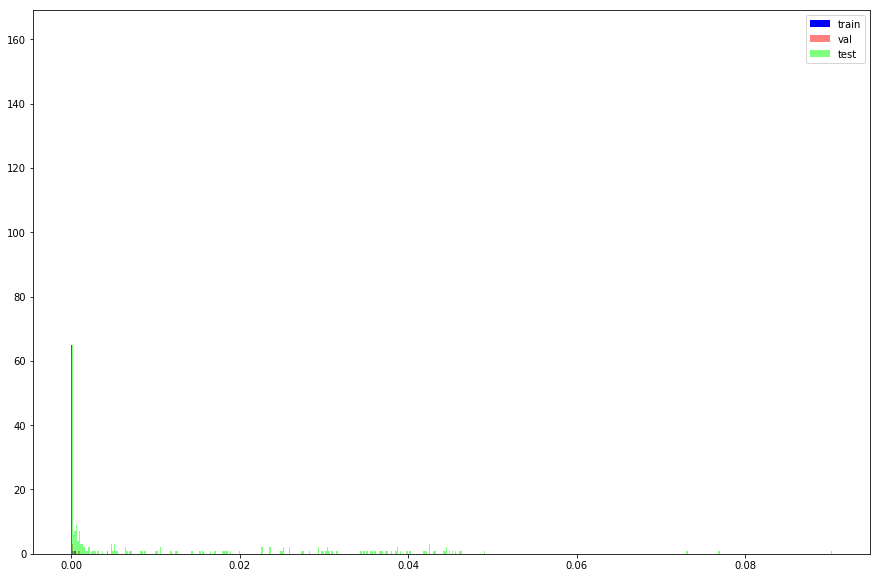

In [185]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=500, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [186]:
threshold_var = 1.5 * y_train_preds_var.mean()

In [187]:
train_acc = (y_train_preds_var < threshold_var).mean()
print(train_acc)

0.9017543859649123


### Validation & Test

In [188]:
val_acc = (y_val_preds_var < threshold_var).mean()
print(val_acc)

0.8611111111111112


In [189]:
test_acc = (y_test_preds_var >= threshold_var).mean()
print(test_acc)

0.8160377358490566


Done!